# Modelling the eclipse profile of PSR J0737-3039A by the magnetosphere of PSR J0737-3039B


Throughout this notebook we will follow the pedagogy of Lyutikov & Thompson (2005), whom developed the original dipole B-field model for describing the Double Pulsar eclipses.

In [1]:
import numpy as np
from scipy.integrate import simps
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Lyutikov & Thompson (2005) define a Cartesian coordinate system in which they model the eclipses of A by B. In this system, Pulsar B is placed at the origin where x is the line-of-sight plane from the pulsar to Earth, y lies along the projected oribtal direction of Pulsar A, and z is orthogonal to the x-y plane (normal to the orbital plane of the binary). In this system the apparent motion of Pulsar A around B occurs at a fixed value of $z = z_{0}$.

We start by converting the oribtal phase to units of y (cm) as
$$y(t) = \frac{\pi a}{2} \Big[ 1 - \Big( \frac{\phi_{\mathrm{orb}}}{90^{\circ}} \Big) \Big],$$
where $a$ is the semi-major axis in cm and $\phi_{\mathrm{orb}}$ is the orbital phase in degrees. Note: $\phi_{\mathrm{orb}} = 0^{\circ}$ corresponds to the eclipse centre.

In [2]:
def orbital_phase_to_y(semi_major_axis, phi_orb):
    """ 
    Convert orbital phase to Cartesian y-coordinates.
    Parameters
    -----------
    semi_major_axis: scalar
        Semi-major axis of the orbit (cm)
    phi_orb: array-like
        Orbital phase (deg)
    """
    return 0.5 * (np.pi * semi_major_axis) * (1 - (phi_orb/(90 * u.deg)))

From here, we can calculate the radial distance of any given point to Pulsar B as
$$ r(x, t) = \sqrt{x^{2} + y^{2}(t) + z_{0}^{2}}. $$

In [3]:
def radial_distance(x, y, z_0):
    """
    Distance from a given point to pulsar B.
    Parameters
    ----------
    x: array-like
        x-coordinate (cm)
    y: array-like
        y-coordinate (cm)
    z_0: array-like
        z-coordinate (cm)
    """
    return np.sqrt(x**2 + y**2 + z_0**2)

The polar angle between the magnetic axis and $\mathbf{r}$ is determined from the unit vector $\hat{\mathbf{\mu}}(t)$ that is parallel to $\mathbf{\mu}_{B}(t)$,
$$ \cos(\theta_{\mu}) =  \frac{\hat{\mathbf{\mu}} \cdot \mathbf{r}}{r}$$.
We can express the components of $\hat{\mathbf{\mu}}$ in a coordinate system that is aligned with the spin axis ($\Omega_{B}$) as
$$ \hat{\mu}^{\Omega}_{x} = \sin(\alpha) \cos(\Omega_{B}t), $$
$$ \hat{\mu}^{\Omega}_{y} = \sin(\alpha) \sin(\Omega_{B}t), $$
$$ \hat{\mu}^{\Omega}_{z} = \cos(\alpha), $$
where $\alpha$ is the angle between the spin and magnetic axes.
Transformed into the observer frame, these components are expressed as
$$ \hat{\mu}_{x} = (\hat{\mu}^{\Omega}_{x}\cos(\theta) + \hat{\mu}^{\Omega}_{z}\sin(\theta))\cos(\phi) - \hat{\mu}^{\Omega}_{y}\sin(\theta), $$
$$ \hat{\mu}_{y} = \hat{\mu}^{\Omega}_{y}\cos(\phi) + (\hat{\mu}^{\Omega}_{x}\cos(\theta) + \hat{\mu}^{\Omega}_{z}\sin(\theta))\sin(\theta), $$
$$ \hat{\mu}_{z} = \hat{\mu}^{\Omega}_{z}\cos(\theta) - \hat{\mu}^{\Omega}_{x}\sin(\theta). $$

In [4]:
def spin_aligned_magnetic_polar_angle(time, alpha):
    """
    Returns the x,y & z components of the unit vector projected along the spin axis.
    Parameters
    ----------
    time: array-like
        Time (s)
    alpha: scalar
        Angle between magnetic and spin axes (deg)
    """
    
    # Rotational rate of Pulsar B in units of degrees/s
    Omega_B = (360 * u.deg) / (2.77 * u.s)
    
    mu_hat_omega_x = np.sin(alpha) * np.cos(Omega_B * time)
    mu_hat_omega_y = np.sin(alpha) * np.sin(Omega_B * time)
    mu_hat_omega_z = np.cos(alpha)
    
    return mu_hat_omega_x, mu_hat_omega_y, mu_hat_omega_z

In [5]:
def Cartesian_magnetic_polar_angle(time, alpha, theta, phi):
    """
    Returns the unit vector components in Cartesian coordinates.
    Parameters
    ----------
    time: array-like
        Time (s)
    alpha: scalar
        Angle between magnetic and spin axes (deg)
    Omega_B: scalar
        Rate at which the spin-axis precesses (deg/yr)
    theta: scalar
        Projected angle of the spin axis in the x-z plane (deg)
    phi: scalar
        Projected angle of the spin axis in the x-y plane (deg)
    """
    mu_hat_omega_x, mu_hat_omega_y, mu_hat_omega_z = spin_aligned_magnetic_polar_angle(
        time, alpha)
    
    mu_hat_x = (mu_hat_omega_x*np.cos(theta) + mu_hat_omega_z*np.sin(theta)
               )*np.cos(phi) - mu_hat_omega_y*np.sin(phi)
    mu_hat_y = mu_hat_omega_y*np.cos(phi) + (mu_hat_omega_x*np.cos(theta) 
               + mu_hat_omega_z*np.sin(theta))*np.sin(phi)
    mu_hat_z = mu_hat_omega_z*np.sin(theta) - mu_hat_omega_x*np.cos(theta)
    
    return mu_hat_x, mu_hat_y, mu_hat_z

In [6]:
def cosine_polar_angle(mu_hat, coords, r):
    """
    Returns the cosine of the magnetic polar angle.
    Parameters
    ----------
    mu_hat: array-like
        Vector of x, y & z components of mu_hat (unitless)
    coords: array-like
        Cartesian coordinates (cm)
    r: array-like
        Radial coordinates from Pulsar B (cm)
    """
    return sum([i*j for (i, j) in zip(mu_hat, coords)])/r

The strength of Pulsar B's magnetic field at position $\mathbf{x}$ is
$$ B = \frac{\sqrt{ 1 + 3\cos^{2}(\theta_{\mu}) }}{r^{3}} \mu_{B}. $$

In [7]:
def local_B_field(mu_hat, r, mu_B, cos_theta_mu):
    """
    Magnetic field strength along the line of sight.
    Parameters
    ----------
    r: array-like?
        Radial coordinates from Pulsar B (cm)
    mu_B: scalar?
        Magnitude of the magnetic moment (deg?)
    cos_theta_mu: array-like
        Cosine of the polar angle (unitless)
    """
    return mu_B * np.sqrt(1 + 3*(cos_theta_mu**2))/(r**3)

The angle between the local magnetic field direction and the line-of-sight is given by:
$$ \cos(\kappa) = \frac{B_{x}}{B} = \frac{3\cos(\theta_{\mu})(x/r) - \hat{\mu}_{x}}{\sqrt{1 + 3\cos^{2}(\theta_{\mu})}} $$

In [8]:
def kappa(x, r, mu_x, cos_theta_mu):
    """
    Angle between the local magnetic field direction and the line-of-sight.
    Parameters
    ----------
    x: array-like
        Values along the line of sight (cm)
    r: array-like
        Radial coordinates from Pulsar B (cm)
    mu_x: array_like
        Unit vector along in the x-direction (cm)
    cos_theta_mu: array-like
        Cosine of the polar angle (unitless)
    """
    
    return 3 * ((cos_theta_mu*(x/r)) - mu_x)/np.sqrt(1 + 3*(cos_theta_mu**2)) * u.rad

Combining all of this together, we can derive the optical depth by integrating over the absorption coefficient for $-R_{\mathrm{mag}} < x < +R_{\mathrm{mag}}$ as
$$ \tau = \xi \int^{+R_{\mathrm{mag}}}_{-R_{\mathrm{mag}}} \Big( \frac{B\sin(\kappa)}{B_{\mathrm{mag}}} \Big) d\Big( \frac{x}{R_{\mathrm{mag}}} \Big) ,$$
where $\xi$ is the characteristic optical depth of Pulsar B's magnetosphere.

In [9]:
def optical_depth(x, xi, B, cos_theta_mu, r, mu_x, B_mag, R_mag):
    """
    Optical depth of Pulsar B's magnetosphere.
    Parameters
    ----------
    x: array-like
        Values along the line of sight (cm)
    xi: scalar
        Characteristic optical depth of B's magnetosphere (unitless)
    B: array-like
        Local dipolar magnetic field strength (G)
    cos_theta_mu: array-like
        Cosine of the angle between the local magnetic field direction and 
        the line-of-sight (unitless)
    B_mag: scalar
        Magnetic field strength at the truncation radius (deg)
    R_mag: scalar
        Truncation radius of B's magnetosphere (cm)
    """
    
    sin_kappa = np.sin(kappa(cos_theta_mu, x/R_mag, r/R_mag, mu_x))
    
    tau = xi * (B * sin_kappa)/B_mag
    
    return simps(tau, x/R_mag)

In [10]:
def eclipse_lightcurve(coords, R_mag, parameters):
    """
    (Currently) returns an estimate of the optical depth due to absorbtion 
    by Pulsar B's magnetosphere.
    Paramters
    ---------
    coords: array-like
        Array containing the Cartesian coordinates (cm)
    R_mag: scalar
        Truncation radius of the magnetosphere (cm)
    parameters: dict
        Dictionary containing values of the magnetic/spin axes offset, alpha, 
        spin-axis co-latitude and longitude, theta & phi (deg)
    """
    # Distance from a given point to pulsar B
    r = radial_distance(x, y, z)
    
    # Unit vector in Cartesian coordinates
    mu_hat = Cartesian_magnetic_polar_angle(time, parameters["alpha"], 
        parameters["theta"], parameters["phi"])
    
    # Cosine of the magnetic polar angle
    cos_theta_mu = cosine_polar_angle(mu_hat, coords, r)
    
    # Angle between the local magnetic field direction and the line-of-sight
    sin_kappa = np.sin(kappa(x, r, mu_hat[0], cos_theta_mu))
    
    # Local magnetic field strength along the line of sight
    B = local_B_field(mu_hat, r, (1.59e12 * u.G * (1.3e6 * u.cm)**3), cos_theta_mu)

    # Optical depth
    tau = np.array([])
    for i in range(0, n):
        if r[i]/(np.sin(np.arccos(cos_theta_mu[i]))**2) < R_mag:
            tau = np.append(tau, optical_depth(x, 2, B[i], cos_theta_mu[i], 
                r[i], mu_hat[0], max(B), R_mag))
        else:
            tau = np.append(tau, 0.0)
        
    return tau

In [11]:
a_sin_i = 1.415032 * u.s
semi_major_axis = 8.8e10 * u.cm#((c.c * a_sin_i)/np.sin(88.1 * u.deg)).cgs

In [12]:
n = 1024
time = np.linspace(0, 4*24.5, n) * u.s
phi_orb = np.linspace(90-2, 90+2, n) * u.deg

R_mag = 1.5e9 * u.cm # orbital_phase_to_y(semi_major_axis, (90-1.29) * u.deg)

y = orbital_phase_to_y(semi_major_axis, phi_orb)
x = np.linspace(-R_mag.value, R_mag.value, n) * u.cm
z = np.ones(n) * -0.543 * R_mag # -7.5e8 * u.cm
coords = np.array([x, y, z]) * u.cm

In [13]:
parameters = dict(alpha=71*u.deg, theta=30*u.deg, phi=51*u.deg)

In [14]:
tau = eclipse_lightcurve(coords, R_mag, parameters)

/Users/other/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [15]:
dt = time[1] - time[0]
sigma = (dt)/np.sqrt(2 * np.pi)
smoothed_vals = np.zeros(tau.shape)
for i in range(0, len(time)):
    kernel = np.exp(-(time - time[i]) ** 2 / (2 * sigma ** 2))
    kernel = kernel / sum(kernel)
    smoothed_vals[i] = sum(tau * kernel)

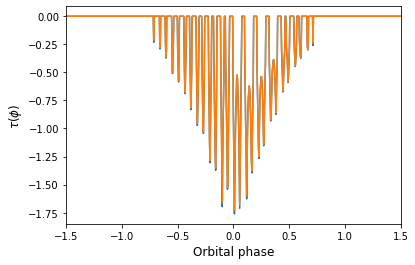

In [16]:
plt.plot(phi_orb-(90*u.deg), tau)
plt.plot(phi_orb-(90*u.deg), smoothed_vals)
plt.xlabel("Orbital phase", fontsize=12)
plt.ylabel(r"$\tau(\phi)$", fontsize=12)
plt.xlim(-1.5, 1.5)
plt.show()

Note: I'm not sure what values to expect for the optical depth, but the above values do seem a little small... 

Still need actual values for $B_{\mathrm{mag}}$ and $\mu_{B}$, so getting those might help.